In [2]:

import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
DATASET_DIR = './data/'
GLOVE_DIR = './glove.6B/'
SAVE_DIR = './'

X = pd.read_csv(os.path.join(DATASET_DIR, 'training_set_rel3.tsv'), sep='\t', encoding='ISO-8859-1')
X = X.dropna(axis=1)
X = X.drop(columns=['rater1_domain1', 'rater2_domain1', 'domain1_score', 'essay_id'])
prompt = X['essay_set']
# X = X.drop(columns=['essay_set'])
y = open(os.path.join(DATASET_DIR, 'prompt.txt')).read().splitlines()
print(len(y))
X.shape

8


(12976, 2)

In [3]:
import numpy as np
import nltk
import re
from nltk.corpus import stopwords

def essay_to_wordlist(essay_v, remove_stopwords):
    """Remove the tagged labels and word tokenize the sentence."""
    essay_v = re.sub("[^a-zA-Z]", " ", essay_v)
    words = essay_v.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    return (words)

def essay_to_sentences(essay_v, remove_stopwords):
    """Sentence tokenize the essay and call essay_to_wordlist() for word tokenization."""
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(essay_v.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(essay_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

def makeFeatureVec(words, model, num_features):
    """Make Feature Vector from the words list of an Essay."""
    featureVec = np.zeros((num_features,),dtype="float32")
    num_words = 0.
    index2word_set = set(model.wv.index_to_key)
    for word in words:
        if word in index2word_set:
            num_words += 1
            featureVec = np.add(featureVec,model.wv[word])        
    featureVec = np.divide(featureVec,num_words)
    return featureVec

def getAvgFeatureVecs(essays, model, num_features):
    """Main function to generate the word vectors for word2vec model."""
    counter = 0
    essayFeatureVecs = np.zeros((len(essays),num_features),dtype="float32")
    for essay in essays:
        essayFeatureVecs[counter] = makeFeatureVec(essay, model, num_features)
        counter = counter + 1
    return essayFeatureVecs

In [4]:
sentences = []
for i in y:
  sentences += essay_to_sentences(i, remove_stopwords = True)

for essay in X['essay']:
  sentences += essay_to_sentences(essay, remove_stopwords = True)


In [5]:
from gensim.models import Word2Vec
num_features = 300 
min_word_count = 40
num_workers = 4
context = 10
downsampling = 1e-3

# print("Training Word2Vec Model...")
# model = Word2Vec(sentences, workers=num_workers, vector_size=num_features, min_count = min_word_count, window = context, sample = downsampling)

# model.init_sims(replace=True)
# model.save('./w2v_otd.model')

model = Word2Vec.load("./w2v_otd.model")


In [6]:
clean_essays = []
for essay_v in X['essay']:
    clean_essays.append(essay_to_wordlist(essay_v, remove_stopwords=True))
data_vecs = getAvgFeatureVecs(clean_essays, model, num_features)

In [7]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_z_scores(cosine_similarities, mean, std_dev):
    """Calculate the z-scores based on cosine similarities."""
    return (cosine_similarities - mean) / std_dev 

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid= train_test_split(data_vecs, prompt, test_size=0.2, random_state=42)
y_valid = np.array(y_valid)

true = y_valid.copy()
np.random.seed(42)
np.random.shuffle(y_valid)
true = [1 if true[i] == y_valid[i] else 0 for i in range(y_valid.shape[0])]

In [10]:


y_sentences = []
for i in y:
  y_sentences.append(essay_to_wordlist(i, remove_stopwords = True))
prompt_vector = getAvgFeatureVecs(y_sentences, model, num_features)

train_essays = data_vecs

# cos similarity between training essays and its corresponding prompt
prompt_similarities = np.diag(cosine_similarity(X_train, prompt_vector[y_train- 1]))

mean_prompt_cos = np.mean(prompt_similarities)
std_dev_prompt_cos = np.std(prompt_similarities)

def modelA(novel_essays, novel_essays_prompt):
  '''
  predict off-topicity using cosine similarity and z-scores
  '''
  # cos similarity between novel essay and training essays
  cosine_similarities = cosine_similarity(novel_essays, X_train)

  max_cos_sim = np.max(cosine_similarities)
  prompt_cos = np.diag(cosine_similarity(novel_essays, novel_essays_prompt))

  mean_max_cos_sim = np.mean(cosine_similarities)
  std_dev_max_cos_sim = np.std(cosine_similarities)

  z_scores_max_cos_sim = calculate_z_scores(max_cos_sim, mean_max_cos_sim, std_dev_max_cos_sim)
  z_scores_prompt_cos = calculate_z_scores(prompt_cos, mean_prompt_cos, std_dev_prompt_cos)

  final_score = (z_scores_max_cos_sim + z_scores_prompt_cos) / 2
  # if score < 0 then pred = 0, else pred = 1
  return final_score

In [15]:
pred_proba = modelA(X_valid, prompt_vector[y_valid - 1])
print(pred_proba)

[ 0.2555884   0.59432197 -0.90641654 ... -0.43111813  0.25972068
  0.50426465]


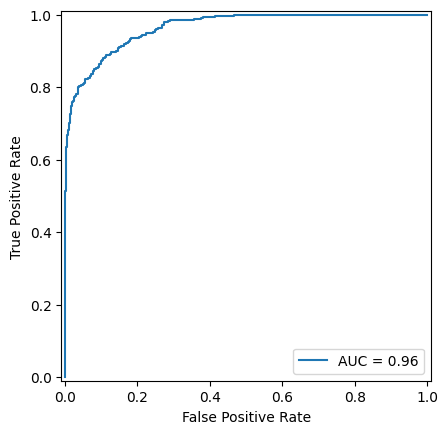

0.60482925


In [24]:
# confusion matrix, roc curve, accuracy
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt

fpr, tpr, threshold = roc_curve(true, pred_proba)
roc_auc = auc(fpr, tpr)

roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_display.plot()
plt.show()

# find threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = threshold[optimal_idx]
print(optimal_threshold)

In [25]:
# confusion matrix, accuracy
pred = [1 if i >= optimal_threshold else 0 for i in pred_proba]
print(confusion_matrix(true, pred))
print(accuracy_score(true, pred))


[[2027  240]
 [  39  290]]
0.8925269645608629
